In [75]:
from music21 import converter, instrument, note, chord, stream, midi
from google.colab import files
import glob
import os
import gzip
import tarfile    
from torchvision import datasets                  
import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

assert torch.cuda.is_available()

In [2]:
# Import Drive for easier saving
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def download_data(filepath):
    if not os.path.exists(os.path.join(filepath, 'mozart_sonatas.tar.gz')):
      datasets.utils.download_url('https://github.com/Foundations-of-Applied-Mathematics/Data/raw/master/RNN/mozart_sonatas.tar.gz', filepath, 'mozart_sonatas.tar.gz', None)

    print('Extracting {}'.format('mozart_sonatas.tar.gz'))
    gzip_path = os.path.join(filepath, 'mozart_sonatas.tar.gz')
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())

    print('Untarring {}'.format('mozart_sonatas.tar'))
    tar_path = os.path.join(filepath,'mozart_sonatas.tar')
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

# download_data('drive/MyDrive/Colab')

**Problem 1**:

Download the data.
Write a function that accepts the path to the .mid files, parses the files, and returns a list of the $119348$ pitches as strings. 
For the Chords, join the pitches of the notes in the chords with a . as in D3.D2.

Print the length of your list and the number of unique pitches.


In [4]:
if os.getcwd() != "content/drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/":
  os.chdir("/content/drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/")

pitches = []
for file in os.listdir():
  print(file)
  midi = converter.parse(file)
  notes_to_parse = instrument.partitionByInstrument(midi).parts[0].recurse()
  
  for element in notes_to_parse:
    if isinstance(element, note.Note):
      pitches.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
      pitches.append(".".join([str(i) for i in element.pitches]))

piano_sonata_279.mid
piano_sonata_280.mid
piano_sonata_282.mid
piano_sonata_281.mid
piano_sonata_283.mid
piano_sonata_284.mid
piano_sonata_309.mid
piano_sonata_311.mid
piano_sonata_331.mid
piano_sonata_330.mid
piano_sonata_310.mid
piano_sonata_400.mid
piano_sonata_457.mid
piano_sonata_333.mid
piano_sonata_593.mid
piano_sonata_545.mid
piano_sonata_576.mid
piano_sonata_332.mid
piano_sonata_547.mid
piano_sonata_570.mid
5_epochs


ConverterFileException: ignored

In [88]:
print(pitches[100:105])
print("Total number of pitches:", len(pitches))
print("Number of unique pitches:", len(set(pitches)))

['B3', 'G4', 'D4', 'G4', 'B3']
Total number of pitches: 119348
Number of unique pitches: 741


**Problem 2.** 

Using the list returned in Problem 1, create the training and testing DataLoaders.
Make sure to do all of the following steps:


1) Convert the pitches to integers.
2) Split the data into Long tensors of length 100.
3) Create the labels.
4) Randomly split the data into training and test sets using an 80/20 split.
5) Create the DataLoaders for both sets of data, using batch_size=128 for the training data and batch_size=1 for the test data.
 

Print the length of each DataLoader.


In [89]:
d = dict([(y,x) for x,y in enumerate(sorted(set(pitches)))])
pitches_to_ints = [d[x] for x in pitches]
pitches_to_ints[:10]

X = [torch.LongTensor(pitches_to_ints[i:i+99]) for i in range(len(pitches_to_ints) - 100)]
y = [pitches_to_ints[i+100] for i in range(len(pitches_to_ints) - 100)]

X_train, X_test, y_train, y_test = train_test_split(
                                          X, y, test_size=0.2, random_state=42)
train_loader = DataLoader([[X,y] for X, y in zip(X_train, y_train)],
                          batch_size=128,
                          drop_last=True)
test_loader = DataLoader([[X,y] for X, y in zip(X_test, y_test)],
                         batch_size=32,
                         drop_last=True)

print(len(train_loader), len(test_loader))

745 745


**Problem 3**

Create the network class.
Include at least $3$ LSTM layers, each followed by Dropout layers with probability $.3.$
Also have at least $2$ Linear layers.
The last LSTM layer and each of the Linear layers should be followed by a BatchNorm1d layer, for at least $3$ total batchnorm layers.
The final layer should be a Softmax activation.

Initialize the model, loss as CrossEntropyLoss, and optimizer as RMSprop.

Train the model until the accuracy is above 95\%. This can take?



After taking a backwards step during training, scale the gradients using 
nn.utils.clip_grad_norm_(model.parameters(), 5)
This will ensure that the gradients are reasonably sized so that the model can learn.

At the end of each epoch, calculate the accuracy and mean loss on the test data.
Remember to change the model to eval() mode when running the test data and train() when running on the training data.

After the accuracy is above 95\%, plot the training and test losses versus epochs on the same plot.
Plot the accuracy versus epochs.


In [90]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class RNN(nn.Module):
  '''
  Recurrent Neural Network Class
  '''
  def __init__(self, n_notes, embedding_dim):
    super(RNN, self).__init__()
    # initialize layers
    self.hidden_size = 512
    self.num_layers = 3
    self.dropout = 0.3
    self.n_notes = n_notes
    self.embedding = nn.Embedding(n_notes,embedding_dim)

    self.lstm = nn.LSTM(embedding_dim, self.hidden_size, self.num_layers, batch_first=True, dropout=.3)
    self.batch1 = nn.BatchNorm1d(self.hidden_size)
    self.batch2 = nn.BatchNorm1d(64)
    self.dropout = nn.Dropout(.3)
    self.linear1 = nn.Linear(self.hidden_size, 64)
    self.linear2 = nn.Linear(64, self.n_notes)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x, hidden):
    # forward pass
    embeds = self.embedding(x)
    lstm_out, hidden = self.lstm(embeds, hidden)
    out = self.dropout(self.batch1(lstm_out[:,-1])) 
    out = self.batch2(self.linear1(out))
    return self.softmax(self.linear2(out)), hidden

  def initHidden(self, batch_size):
    # initialize the hidden layers
    weight = next(self.parameters()).data
    h0 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
    h1 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
    return (h0, h1)


In [91]:
model = RNN(741, 32)
model = model.to(device)
model.train()
optimizer = torch.optim.RMSprop(model.parameters(),lr=.001)
objective = nn.CrossEntropyLoss()

loss:3.9704: 100%|██████████| 745/745 [01:45<00:00,  7.05it/s]
loss:3.5700: : 746it [01:57,  6.34it/s]
loss:3.3412: : 746it [01:57,  6.35it/s]
loss:3.2753: : 746it [01:57,  6.34it/s]
loss:3.1150: : 746it [01:57,  6.34it/s]
loss:2.9743: : 746it [01:57,  6.34it/s]
loss:2.7726: : 746it [01:58,  6.30it/s]
loss:2.7174: : 746it [01:57,  6.34it/s]
loss:2.4310: : 746it [01:57,  6.34it/s]
loss:2.3710: : 746it [01:57,  6.34it/s]
loss:2.0723: : 746it [01:57,  6.34it/s]
loss:1.9005: : 746it [01:57,  6.34it/s]
loss:1.7159: : 746it [01:57,  6.34it/s]
loss:1.7149: : 746it [01:57,  6.34it/s]
loss:1.5026: : 746it [01:57,  6.34it/s]
loss:1.4843: : 746it [01:57,  6.35it/s]
loss:1.2951: : 746it [01:57,  6.34it/s]
loss:1.3305: : 746it [01:57,  6.34it/s]
loss:1.2281: : 746it [01:57,  6.34it/s]
loss:1.2339: : 746it [01:57,  6.33it/s]
loss:1.0689: : 746it [01:57,  6.33it/s]
loss:0.9327: : 746it [01:57,  6.34it/s]
loss:0.9996: : 746it [01:57,  6.33it/s]
loss:0.8292: : 746it [01:57,  6.33it/s]
loss:1.0058: : 74

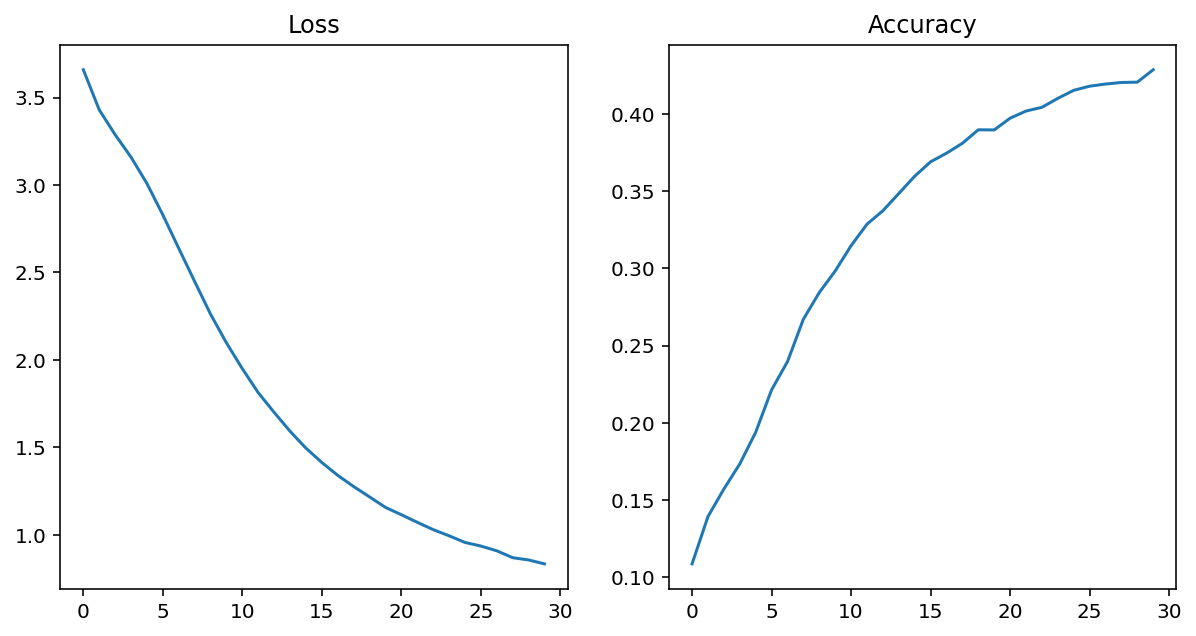

In [93]:
n_epochs = 30
total_losses = []
accuracies = []

for i in range(n_epochs):
  loop = tqdm(total=len(train_loader), position=0)
  loop.update()
  total_loss = 0
  for batch, (x, y_truth) in enumerate(train_loader):
    optimizer.zero_grad() # Zero out the the gradients

    x, y_truth = x.to(device), y_truth.to(device)
    (h0, h1) = model.initHidden(128)
    # pass data through the model
    y_hat, (h0, h1) = model(x, (h0,h1))
    h0 = h0.detach()
    h1 = h1.detach()

    loss = objective(y_hat, y_truth) # Calculate loss
    loss.backward() # Compute gradients
    optimizer.step()
    nn.utils.clip_grad_norm_(model.parameters(), 5)

    loop.set_description('loss:{:.4f}'.format(loss.item()))
    total_loss += loss.item()
    loop.update()

  # At the end of each epoch,
  # Calculate the man loss of the training data for that epoch
  total_losses.append(total_loss / len(train_loader))
  # Then calculate the accuracy of the model on the validation data
  model.eval()
  accuracy = 0
  for batch, (x, y_truth) in enumerate(test_loader):
    x, y_truth = x.to(device), y_truth.to(device)
    (h0, h1) = model.initHidden(32)
    y_hat, (h0, h1) = model(x, (h0,h1))
    pred = torch.argmax(y_hat, dim=1)
    h0 = h0.detach()
    h1 = h1.detach()
    accuracy += sum((y_truth == pred))
  accuracies.append(accuracy / (32*len(test_loader)))
  model.train()
  filepath = str(i) + "_epochs"
  torch.save({
    'epoch': i,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,}, filepath)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(total_losses)
axs[0].set_title("Loss")
axs[1].plot([i.item() for i in accuracies])
axs[1].set_title("Accuracy")
plt.show()

**Problem 4.** 
Write a function that randomly chooses a sequence in the test data and predicts
the next 500 elements. 
Return a list of the 600 pitches in the sequence.

In [ ]:
def load_model(filename):
  """ Load a saved model to continue training or evaluate """
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model = RNN(741, 32)
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.RMSprop(model.parameters(),lr=.001)

  checkpoint = torch.load(filename,map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  last_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  model.eval() # For evaluation only
  
  return model, criterion, optimizer

In [94]:
# model, criterion, optimizer = load_model("29_epochs")
model.eval()
model = model.to(device)
rand_loader = DataLoader([[X,y] for X, y in zip(X_test, y_test)],
                         batch_size=1,
                         drop_last=True,
                         shuffle=True)

for batch, (x, y_truth) in enumerate(rand_loader):
    x, y_truth = x.to(device), y_truth.to(device)
    break
for i in range(500):
  (h0, h1) = model.initHidden(1)
  y_hat, (h0, h1) = model(x[:, i:i+99], (h0,h1))
  pred = torch.argmax(y_hat)
  h0 = h0.detach()
  h1 = h1.detach()
  pred = pred.view(1, 1)
  x = torch.cat((x.T, pred)).T

**Problem 5.** 
Convert the sequence from Problem 4 into note and chord objects and save it to
'mozart.mid'.

In [95]:
chord_pitches = [list(d.keys())[list(d.values()).index(i)] for i in x.T]

In [98]:
output_notes = []
for i, pitch in enumerate(chord_pitches):
  o = np.random.choice([0, .25, .5], p=[1999/3673, 1167/3673, 507/3673])
  # If it's a note
  if "." not in pitch:
    new_note = note.Note(pitch)
    new_note.storedInstrument = instrument.Piano()
    new_note.offset = (o + i) / 3
    output_notes.append(new_note)
  # If it's a pitch
  else:
    temp = []
    for n in pitch.split("."):
      new_note = note.Note(n)
      new_note.storedInstrument = instrument.Piano()
      temp.append(new_note)
    new_chord = chord.Chord(temp)
    new_chord.offset = (o + i) / 3
    output_notes.append(new_chord)

In [99]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp="mozart.mid")

'mozart.mid'